In [1]:
import os
import h5py
import glob
import torch.utils.data as data
import torch.optim as optim
import torch.nn.init as init
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
with h5py.File('data/processed/nowcast_training_000.h5','r') as hf:
    print("Keys: %s" % hf.keys())
    print(len(hf['IN_vil']))

Keys: <KeysViewHDF5 ['IN_ir069', 'IN_ir107', 'IN_lght', 'IN_vil', 'OUT_vil']>
5088


In [3]:
class SevirDataset(data.Dataset):

    def __init__(self, root = '..', type = 'train'):
        
        DEST_TRAIN_FILE= os.path.join(root,'data/processed/nowcast_training_000.h5')
        DEST_TRAIN_META=os.path.join(root, 'data/processed/nowcast_training_000_META.csv')
        DEST_TEST_FILE= os.path.join(root, 'data/processed/nowcast_testing_000.h5')
        DEST_TEST_META= os.path.join(root, 'data/processed/nowcast_testing_000_META.csv')

        if type=='train':
            self.data_file = DEST_TRAIN_FILE
            self.meta_file = DEST_TRAIN_META 
        else:
            self.data_file = DEST_TEST_FILE
            self.meta_file = DEST_TEST_META

    def __getitem__(self, index):
                
        with h5py.File(self.data_file,'r') as hf:
            input_img_seq = hf['IN_vil'][index].astype(float)
            output_img_seq = hf['OUT_vil'][index].astype(float)
        return input_img_seq, output_img_seq
    
    def __len__(self):
        with h5py.File(self.data_file,'r') as hf:
            return len(hf['IN_vil'])

In [4]:
sevir_dataset = SevirDataset(root='')
train_dataloader = data.DataLoader(sevir_dataset, batch_size=8, shuffle=True)

In [5]:
input_img_seq, output_img_seq = next(iter(train_dataloader))

In [6]:
input_img_seq = input_img_seq.permute(0,3,1,2).unsqueeze(4)

In [7]:
input_img_seq.shape

torch.Size([8, 13, 384, 384, 1])

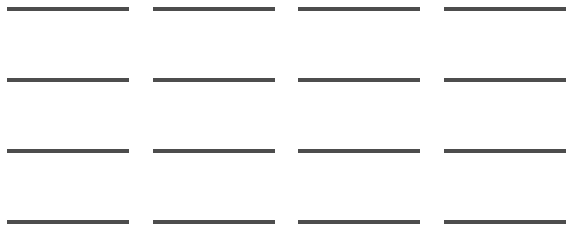

In [8]:
from display import get_cmap

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)

fig,axs=plt.subplots(4,4,figsize=(10,5))
idx = 0
for i in range(0,4):
    for j in range(0,4):
        if idx < (input_img_seq[0].shape[2]):
            axs[i,j].imshow(input_img_seq[0][:,:,idx], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=12):
        super(UNet, self).__init__()

    # Encoder
        # input: 384x384x13
        self.e11 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1) # output: 384x384x16
        self.be11 = nn.BatchNorm2d(16)
        self.ae11 = nn.ReLU()
        self.e12 = nn.Conv2d(16, 16, kernel_size=3, padding=1) # output: 384x384x16
        self.be12 = nn.BatchNorm2d(16)
        self.ae12 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 192x192x16

        # input: 192x192x16
        self.e21 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # output: 192x192x32
        self.be21 = nn.BatchNorm2d(32)
        self.ae21= nn.ReLU()
        self.e22 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 192x192x32
        self.be22 = nn.BatchNorm2d(32)
        self.ae22= nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 96x96x32

        # input: 96x96x32
        self.e31 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 96x96x64
        self.be31 = nn.BatchNorm2d(64)
        self.ae31= nn.ReLU()
        self.e32 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 96x96x64
        self.be32 = nn.BatchNorm2d(64)
        self.ae32= nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 48x48x64

        # input: 48x48x64
        self.e41 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 48x48x128
        self.be41 = nn.BatchNorm2d(128)
        self.ae41= nn.ReLU()
        self.e42 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 48x48x128
        self.be42 = nn.BatchNorm2d(128)
        self.ae42= nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 24x24x128

        # input: 24x24x128
        self.e51 = nn.Conv2d(128, 512, kernel_size=3, padding=1) # output: 24x24x512
        self.be51 = nn.BatchNorm2d(512)
        self.ae51= nn.ReLU()
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 24x24x512
        self.be52 = nn.BatchNorm2d(512)
        self.ae52= nn.ReLU()


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2)
        self.upb1 = nn.BatchNorm2d(256)
        self.d11 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bd11 = nn.BatchNorm2d(128)
        self.ad11= nn.ReLU()
        self.d12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bd12 = nn.BatchNorm2d(128)
        self.ad12= nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upb2 = nn.BatchNorm2d(128)
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bd21 = nn.BatchNorm2d(64)
        self.ad21= nn.ReLU()
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bd22 = nn.BatchNorm2d(64)
        self.ad22= nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upb3 = nn.BatchNorm2d(64)
        self.d31 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bd31 = nn.BatchNorm2d(32)
        self.ad31= nn.ReLU()
        self.d32 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bd32 = nn.BatchNorm2d(32)
        self.ad32= nn.ReLU()

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.upb4 = nn.BatchNorm2d(32)
        self.d41 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bd41 = nn.BatchNorm2d(16)
        self.ad41= nn.ReLU()
        self.d42 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bd42 = nn.BatchNorm2d(16)
        self.ad42= nn.ReLU()
        

        # Output layer
        self.outconv = nn.Conv2d(16, out_channels, kernel_size=1)    

    def forward(self, x):
        #Encoder
        MEAN=33.44
        SCALE=47.54
        # x = (x-MEAN)/SCALE
        out1 = self.ae11(self.be11(self.e11(x)))
        out1 = self.ae12(self.be12(self.e12(out1)))
        out2 = self.pool1(out1)

        out2 = self.ae21(self.be21(self.e21(out2)))
        out2 = self.ae22(self.be22(self.e22(out2)))
        out3 = self.pool2(out2)

        out3 = self.ae31(self.be31(self.e31(out3)))
        out3 = self.ae32(self.be32(self.e32(out3)))
        out4 = self.pool3(out3)

        out4 = self.ae41(self.be41(self.e41(out4)))
        out4 = self.ae42(self.be42(self.e42(out4)))
        out5 = self.pool4(out4)

        out5 = self.ae51(self.be51(self.e51(out5)))
        out5 = self.ae52(self.be52(self.e52(out5)))

        # Decoder
        out = self.upconv1(out5)
        out = torch.cat([out, out4], dim=1)
        out = self.ad11(self.upb1(out))
        out = self.ad11(self.bd11(self.d11(out)))
        out = self.ad12(self.bd12(self.d12(out)))

        out = self.upconv2(out)
        out = torch.cat([out, out3], dim=1)
        out = self.ad21(self.upb2(out))
        out = self.ad21(self.bd21(self.d21(out)))
        out = self.ad22(self.bd22(self.d22(out)))

        out = self.upconv3(out)
        out = torch.cat([out, out2], dim=1)
        out = self.ad31(self.upb3(out))
        out = self.ad31(self.bd31(self.d31(out)))
        out = self.ad32(self.bd32(self.d32(out)))

        out = self.upconv4(out)
        out = torch.cat([out, out1], dim=1)
        out = self.ad41(self.upb4(out))
        out = self.ad41(self.bd41(self.d41(out)))
        out = self.ad42(self.bd42(self.d42(out)))

        out = self.outconv(out)

        return out

In [10]:
net = UNet()
net.cuda()

UNet(
  (e11): Conv2d(13, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (be11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ae11): ReLU()
  (e12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (be12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ae12): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (be21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ae21): ReLU()
  (e22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (be22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ae22): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (be31): BatchNorm

In [ ]:
total_params = sum(
	param.numel() for param in net.parameters()
)
total_params

In [ ]:
# define optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# define loss
L1Loss = nn.L1Loss()
# SmoothL1Loss = nn.SmoothL1Loss()

In [ ]:
import time
epochs = 10
for epoch in range(epochs):
    running_loss = 0.
    for input_data in train_dataloader:
        input_img_seq, output_img_seq = input_data

        input_img_seq = input_img_seq.type(torch.cuda.FloatTensor).permute(0,3,1,2)
        output_img_seq = output_img_seq.type(torch.cuda.FloatTensor).permute(0,3,1,2)

        optimizer.zero_grad()

        t0 = time.time()
        output = net(input_img_seq)
        loss = L1Loss(output,output_img_seq)
        loss.backward()
        optimizer.step()
        t1 = time.time()
        running_loss += loss.item()
        print('Timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(epoch) + ' || Loss: %.4f ' % \
                (running_loss))

In [ ]:
torch.save(net,'unet.pth')

In [ ]:
output.shape

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(10,5))
plot_output = output.permute(0,2,3,1).cpu().detach().numpy()
idx = 0
for i in range(0,4):
    for j in range(0,4):
        if idx < (plot_output[15].shape[2]):
            axs[i,j].imshow(plot_output[0][:,:,idx], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()

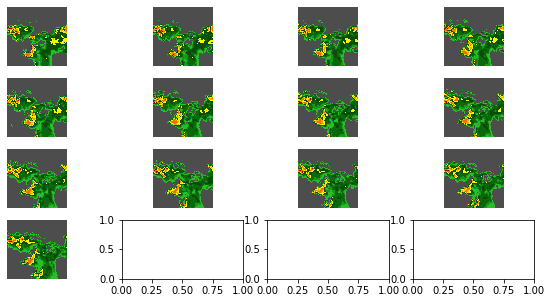

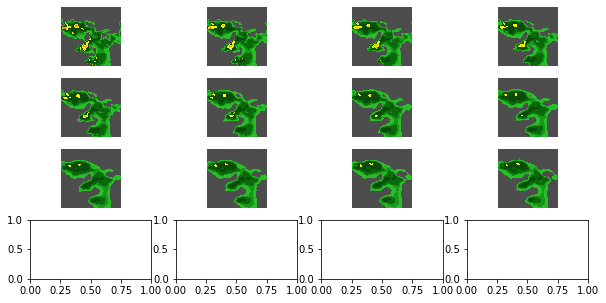

In [11]:
sevir_test_dataset = SevirDataset(root='',type='test')
test_dataloader = data.DataLoader(sevir_test_dataset, batch_size=8, shuffle=True)
input_img_seq, output_img_seq = next(iter(test_dataloader))

from display import get_cmap

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)

fig,axs=plt.subplots(4,4,figsize=(10,5))
idx = 0
for i in range(0,4):
    for j in range(0,4):
        if idx < (input_img_seq[0].shape[2]):
            axs[i,j].imshow(input_img_seq[0][:,:,idx], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()
net = torch.load('unet.pth')
input_img_seq = input_img_seq.type(torch.cuda.FloatTensor).permute(0,3,1,2)
output = net(input_img_seq)
output = output.permute(0,2,3,1).cpu().detach().numpy()
from display import get_cmap

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)

fig,axs=plt.subplots(4,4,figsize=(10,5))
idx = 0
for i in range(0,4):
    for j in range(0,4):
        if idx < (output[0].shape[2]):
            axs[i,j].imshow(output[0][:,:,idx], cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
            axs[i,j].set_axis_off()
            idx+=1
plt.show()

In [ ]:
import imageio
from PIL import Image as im 
frames = []
for i in range(12):
     frame = output[0][:,:,i]
     frames.append(frame) 
with imageio.get_writer('sample.gif', mode='I') as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(12):
                    writer.append_data(frames[-1])